In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/assessment_data.tsv', sep='\t', parse_dates=True)
df['listing_date'] = pd.to_datetime(df.listing_date)
df['event_datetime'] = pd.to_datetime(df.event_datetime)
df.head()

,event_id,listing_date,event_listing_date_id,taxonomy,event_title,event_datetime,tickets_listed,mean_listing_price,performer_1,performer_2,performer_3,performer_4,venue_name
0,3594116,2017-06-01,3594116_17318,MLB Baseball,Arizona Diamondbacks at Los Angeles Dodgers,2017-07-06 19:10:00,13102.0,48.0,Los Angeles Dodgers,Arizona Diamondbacks,NaN,NaN,Dodger Stadium
1,3594065,2017-06-01,3594065_17318,MLB Baseball,Arizona Diamondbacks at Los Angeles Dodgers,2017-09-06 19:10:00,8942.0,56.0,Los Angeles Dodgers,Arizona Diamondbacks,NaN,NaN,Dodger Stadium
2,3594070,2017-06-01,3594070_17318,MLB Baseball,Arizona Diamondbacks at Los Angeles Dodgers,2017-09-04 17:10:00,10344.0,49.0,Los Angeles Dodgers,Arizona Diamondbacks,NaN,NaN,Dodger Stadium
3,3594118,2017-06-01,3594118_17318,MLB Baseball,Arizona Diamondbacks at Los Angeles Dodgers,2017-07-05 19:10:00,13130.0,32.0,Los Angeles Dodgers,Arizona Diamondbacks,NaN,NaN,Dodger Stadium
4,3594068,2017-06-01,3594068_17318,MLB Baseball,Arizona Diamondbacks at Los Angeles Dodgers,2017-09-05 19:10:00,11642.0,32.0,Los Angeles Dodgers,Arizona Diamondbacks,NaN,NaN,Dodger Stadium


In [3]:
df.dtypes

event_id                          int64
listing_date             datetime64[ns]
event_listing_date_id            object
taxonomy                         object
event_title                      object
event_datetime           datetime64[ns]
tickets_listed                  float64
mean_listing_price              float64
performer_1                      object
performer_2                      object
performer_3                      object
performer_4                      object
venue_name                       object
dtype: object

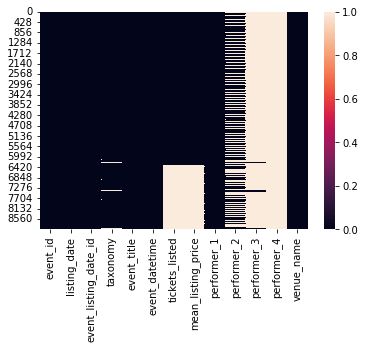

In [4]:
sns.heatmap(df.isna())

# Data Analysis

Understand features more to understand how to build the model

- Understand central tendency and distribution of features
- Understand correlation between features and target variables

In [5]:
df.columns

Index(['event_id', 'listing_date', 'event_listing_date_id', 'taxonomy',
       'event_title', 'event_datetime', 'tickets_listed', 'mean_listing_price',
       'performer_1', 'performer_2', 'performer_3', 'performer_4',
       'venue_name'],
      dtype='object')

## Taxonomy

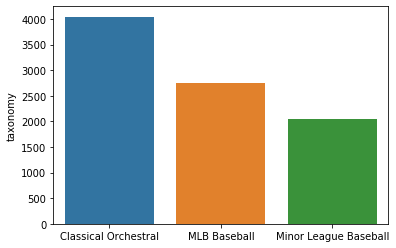

In [6]:
sns.barplot(
    x=df.taxonomy.value_counts().index,
    y=df.taxonomy.value_counts()
)

In [7]:
df.groupby('taxonomy')[['tickets_listed', 'mean_listing_price']].mean()

,tickets_listed,mean_listing_price
taxonomy,,
Classical Orchestral,41.423560,543.278657
MLB Baseball,9240.490428,51.392707
Minor League Baseball,44.144700,35.337706


There is definitely an interaction between taxonomy and the target variables, so we'll end up using these. There are a few `null` values for taxonomy, but we can easily fill them in based on the event title or venue name. Note that we'll have to do this both for `df_model` and `df_holdout`. Afterwards, we can apply one-hot encoding to `taxonomy`.

## Event Datetime

In [18]:
df_analysis = df.copy()
target_variables = ['tickets_listed', 'mean_listing_price']

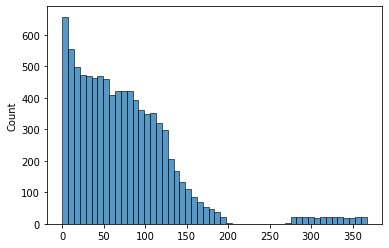

In [9]:
sns.histplot((df_analysis.event_datetime - df_analysis.listing_date).dt.days)

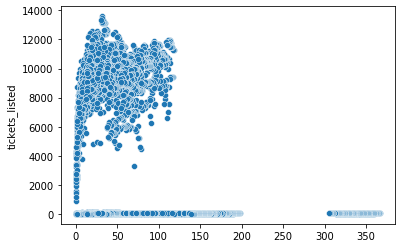

In [10]:
sns.scatterplot(
    x=(df_analysis.event_datetime - df_analysis.listing_date).dt.days,
    y=df_analysis.tickets_listed
)

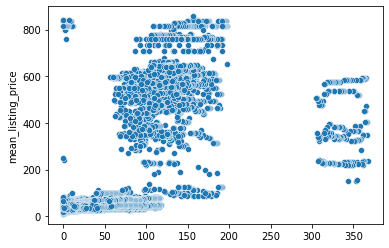

In [11]:
sns.scatterplot(
    x=(df_analysis.event_datetime - df_analysis.listing_date).dt.days,
    y=df_analysis.mean_listing_price
)

It looks like the number of days between the listing date and the event datetime has somewhat of a correlation with tickets listed, but not with mean listing price. The correlation doesn't look to be that strong either, and I might have to transform it into an exponential function. We can either normalize the day difference, or simple split them into two groups: < 250 day difference and 250+ day difference.

## Performers

There are multiple columns for performers, and there are too many unique values if we consider all of them. I can think of a few ways to summarize these pieces of information:

- Only include the # of performers
- Separate groups into top 3 most common of their respective taxonomies (i.e. `has_performer_in_top3_within_taxonomy`)
- Separate groups into top 3 highest listing of their respective taxonomies
- Separate groups into top 3 highest mean listing price of their respective taxonomies

In [12]:
df_analysis.performer_1.value_counts().sort_values(ascending=False)

Los Angeles Philharmonic    4081
Los Angeles Dodgers         2742
Oklahoma City Dodgers        847
New Orleans Baby Cakes       520
Round Rock Express           312
Memphis Redbirds             186
Iowa Cubs                     99
Nashville Sounds              90
M. Ward                       48
Cafe Tacuba                   45
John Pizzarelli               10
Name: performer_1, dtype: int64

In [13]:
df_analysis.performer_2.value_counts().sort_values(ascending=False)

Oklahoma City Dodgers            1207
San Diego Padres                  477
San Francisco Giants              435
Colorado Rockies                  425
Omaha Storm Chasers               391
Gustavo Dudamel                   384
Arizona Diamondbacks              366
Milwaukee Brewers                 252
Tacoma Rainiers                   230
Reno Aces                         216
Atlanta Braves                    198
Minnesota Twins                   159
Hilary Hahn                       150
Chicago White Sox                 147
Kansas City Royals                108
Los Angeles Philharmonic          103
New York Mets                      78
Los Angeles Angels                 49
Gil Shaham                         48
Riccardo Muti                      48
Natalia LaFourcade                 48
Israel Philharmonic Orchestra      45
Cincinnati Reds                    30
Mirga Grazinyte-Tyla               30
Washington Nationals               18
Marc Lowenstein                    13
Colorado Spr

In [14]:
df_analysis.performer_3.value_counts().sort_values(ascending=False)

Gustavo Dudamel               103
Chicago Symphony Orchestra     48
Rhiannon Giddens               48
Hilary Hahn                     1
Los Angeles Angels              1
Name: performer_3, dtype: int64

In [15]:
df_analysis.performer_4.value_counts().sort_values(ascending=False)

Yuja Wang                        10
Los Angeles Children's Chorus     1
Name: performer_4, dtype: int64

In [23]:
performer_columns = ['performer_1', 'performer_2', 'performer_3', 'performer_4']
df_analysis['num_performers'] = df_analysis[performer_columns].notna().sum(axis=1)

In [24]:
df_analysis.groupby('num_performers')[target_variables].mean()

,tickets_listed,mean_listing_price
num_performers,,
1,41.863834,544.853660
2,4859.897301,68.885765
3,217.060606,423.767424
4,34.000000,702.700000


In [25]:
df_analysis.loc[df_analysis.num_performers == 4]

,event_id,listing_date,event_listing_date_id,taxonomy,event_title,event_datetime,tickets_listed,mean_listing_price,performer_1,performer_2,performer_3,performer_4,venue_name,num_performers
44,3555599,2017-06-01,3555599_17318,Classical Orchestral,Los Angeles Philharmonic: Gustavo Dudamel & Yu...,2017-06-02 11:00:00,34.0,842.0,John Pizzarelli,Los Angeles Philharmonic,Gustavo Dudamel,Yuja Wang,Walt Disney Concert Hall,4
45,3209668,2017-06-01,3209668_17318,Classical Orchestral,Los Angeles Philharmonic: Gustavo Dudamel & Yu...,2017-06-01 20:00:00,16.0,839.0,John Pizzarelli,Los Angeles Philharmonic,Gustavo Dudamel,Yuja Wang,Walt Disney Concert Hall,4
46,3209665,2017-06-01,3209665_17318,Classical Orchestral,Los Angeles Philharmonic: Gustavo Dudamel & Yu...,2017-06-04 14:00:00,58.0,761.0,John Pizzarelli,Los Angeles Philharmonic,Gustavo Dudamel,Yuja Wang,Walt Disney Concert Hall,4
47,3209666,2017-06-01,3209666_17318,Classical Orchestral,Los Angeles Philharmonic: Gustavo Dudamel & Yu...,2017-06-03 20:00:00,53.0,798.0,John Pizzarelli,Los Angeles Philharmonic,Gustavo Dudamel,Yuja Wang,Walt Disney Concert Hall,4
184,3555599,2017-06-02,3555599_17319,Classical Orchestral,Los Angeles Philharmonic: Gustavo Dudamel & Yu...,2017-06-02 11:00:00,34.0,842.0,John Pizzarelli,Los Angeles Philharmonic,Gustavo Dudamel,Yuja Wang,Walt Disney Concert Hall,4
185,3209665,2017-06-02,3209665_17319,Classical Orchestral,Los Angeles Philharmonic: Gustavo Dudamel & Yu...,2017-06-04 14:00:00,50.0,798.0,John Pizzarelli,Los Angeles Philharmonic,Gustavo Dudamel,Yuja Wang,Walt Disney Concert Hall,4
186,3209666,2017-06-02,3209666_17319,Classical Orchestral,Los Angeles Philharmonic: Gustavo Dudamel & Yu...,2017-06-03 20:00:00,5.0,241.0,John Pizzarelli,Los Angeles Philharmonic,Gustavo Dudamel,Yuja Wang,Walt Disney Concert Hall,4
322,3209665,2017-06-03,3209665_17320,Classical Orchestral,Los Angeles Philharmonic: Gustavo Dudamel & Yu...,2017-06-04 14:00:00,47.0,815.0,John Pizzarelli,Los Angeles Philharmonic,Gustavo Dudamel,Yuja Wang,Walt Disney Concert Hall,4
323,3209666,2017-06-03,3209666_17320,Classical Orchestral,Los Angeles Philharmonic: Gustavo Dudamel & Yu...,2017-06-03 20:00:00,3.0,250.0,John Pizzarelli,Los Angeles Philharmonic,Gustavo Dudamel,Yuja Wang,Walt Disney Concert Hall,4
458,3209665,2017-06-04,3209665_17321,Classical Orchestral,Los Angeles Philharmonic: Gustavo Dudamel & Yu...,2017-06-04 14:00:00,40.0,841.0,John Pizzarelli,Los Angeles Philharmonic,Gustavo Dudamel,Yuja Wang,Walt Disney Concert Hall,4


In [27]:
df_analysis.loc[df_analysis.taxonomy == 'Classical Orchestral'].groupby('num_performers')[target_variables].agg(['mean', 'count'])

tickets_listed       mean_listing_price      
                         mean count               mean count
num_performers                                              
1                   41.863834  2071         544.853660  2071
2                   38.748815   211         534.142038   211
3                   25.352941    17         371.030588    17
4                   34.000000    10         702.700000    10

# Data Cleaning + Feature Engineering

- Impute `null` values
- Identify and handle severe outliers
- Normalize ratio / interval values
- Feature engineer nominal / ordinal values
- Drop unusable features

# Splitting Data

Upcoming events from 5/20/17 through 8/31/17 are set as null for `tickets_listed` and `mean_listing_price`, so I want to separate this data first as the holdout dataset.

- `df_model`: Dataset that will be used for train/test split
    - `df_train`: Dataset that will be used for training
    - `df_test`: Dataset that will be used for testing
- `df_holdout`: Dataset that will be used as holdout dataset

**Note**: Later, I'll be using k-folds validation, so I'll be using the entirety of `df_model` to train, test, and compare different models instead of using `df_train` and `df_test`.

In [17]:
df_model = df[df.listing_date < '2017-08-01']
df_holdout = df[df.listing_date >= '2017-08-01']